# NN cascade for URZ correct nodes
### With normalization of Features as in iwt_nnet.c : iwt_normalize()

* Radek Hofman, Jan 2018
* we restruict ourselves to data up to 2017/01/01 00:00 for training

### Imports and axiliary functions and stuff

In [58]:
%load_ext sql
%matplotlib inline

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [59]:
import os
import numpy
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
with open(os.path.join('/','home','hofman','.dbp.txt'), 'r') as f: password = f.read().strip()

In [61]:
query = "oracle://hofman:%s@mycelium.ctbto.org:1521/udb" % password
%sql $query

'Connected: hofman@udb'

In [62]:
% sql select count(*) from ml_features where sta='URZ'

0 rows affected.


COUNT(*)
362407


In [63]:
def plot(history, semilog=False):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(history['acc'], label='acc')
    ax.plot(history['val_acc'], label='val_acc')
    ax.set_ylabel('accuracy')
    if semilog:
        ax.set_yscale('log')
    plt.legend(loc='best')
    ax = fig.add_subplot(212)
    ax.plot(history['loss'], label='loss')
    ax.plot(history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    if semilog:
        ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

In [64]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

### What is the misclassification rate now for all arrivals in our DB?

* #(class_iphase != class_phase) / (#automatic which are not noise) 

In [65]:
#select from database required numbers
wrong_type = %sql select count(*) from ml_features where sta='URZ' and class_phase != class_iphase
total_number = %sql select count(*) from ml_features where sta='URZ' and phase!='N' and source!='M'

0 rows affected.
0 rows affected.


In [9]:
print('Percentage of misclassified initial wave types: %3.2f%%' % (wrong_type[0][0]/total_number[0][0]*100))

Percentage of misclassified initial wave types: 47.90%


### Dataframes per class phase type - RESTRICTION TO DATA BEFORE 2017

In [66]:
#1483228800.00000 2017001  2017/01/01 00:00:00.00000 Jan Sun
query = """select * from ml_features where sta='URZ' and class_phase='regS' and time < 1483228800"""
df_S_all = pd.read_sql(query, con=connection)

In [67]:
df_S_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,25050735,URZ,1.125386e+09,Sx,regS,Sn,regS,1.000,A,0.166667,...,1.526004,0.786459,1.174982,-0.1,-0.27,1.216724,0.363039,2.166968,1.844924,0.626604
1,25058004,URZ,1.125423e+09,Lg,regS,Sn,regS,1.925,A,0.444444,...,2.762988,15.337161,15.337161,-0.1,-0.31,0.423843,1.384683,0.724611,6.547078,1.569841
2,25075768,URZ,1.125508e+09,Lg,regS,Sn,regS,1.050,A,0.333333,...,1.395858,1.296030,2.398118,0.0,0.00,0.713705,1.641215,0.940403,1.211333,1.909713
3,25092371,URZ,1.125587e+09,Sn,regS,Sn,regS,0.175,A,0.166667,...,1.746398,5.561389,2.205452,0.0,0.00,1.155050,0.646231,0.997092,1.326985,4.507104
4,25094351,URZ,1.125598e+09,Sn,regS,Sn,regS,1.400,A,0.444444,...,2.816413,5.135686,8.557762,0.0,0.00,1.682028,0.309588,2.783780,8.199625,2.007485


In [70]:
query = """select * from ml_features where sta='URZ' and class_phase='regP' and time < 1483228800"""
df_P_all = pd.read_sql(query, con=connection)

In [71]:
df_P_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,14972252,URZ,1.069735e+09,Pn,regP,Pn,regP,2.94244,A,0.166667,...,1.542596,0.124299,0.176237,0.1,0.100,0.509125,0.983261,0.619635,0.118464,0.058735
1,14992929,URZ,1.070059e+09,Pn,regP,Pn,regP,0.00000,A,0.333333,...,1.301846,1.112025,0.258914,0.2,0.245,3.730434,0.738458,0.704325,0.247701,0.060989
2,15029724,URZ,1.070386e+09,Pn,regP,Pn,regP,0.65000,A,0.166667,...,1.828008,0.132138,0.192003,0.2,0.375,0.629496,0.632947,0.277982,0.542543,0.041916
3,15031571,URZ,1.070403e+09,Pn,regP,Pn,regP,3.22500,A,0.444444,...,1.375773,0.282216,0.589090,0.1,0.050,0.924411,0.941318,0.304547,0.520954,0.131296
4,15073977,URZ,1.070752e+09,Pg,regP,Pn,regP,0.00000,A,0.166667,...,3.529159,0.085323,0.486815,0.1,0.290,0.211185,0.225393,0.257161,0.413598,0.287086


In [72]:
query = """select * from ml_features where sta='URZ' and class_phase='tele' and time < 1483228800"""
df_T_all = pd.read_sql(query, con=connection)

In [73]:
df_T_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,28541585,URZ,1.143123e+09,P,tele,P,tele,0.550,A,0.666667,...,1.702892,0.042081,0.042081,0.0,0.000,0.467387,0.594238,0.057473,0.053682,0.463873
1,28556291,URZ,1.143197e+09,P,tele,P,tele,0.500,A,0.333333,...,1.957241,0.223522,0.223522,0.0,0.000,0.954016,0.705002,1.308694,0.193754,0.114283
2,28557837,URZ,1.143204e+09,P,tele,P,tele,3.100,A,0.333333,...,1.190828,0.240041,0.613747,0.0,-0.195,0.577677,1.020239,0.372745,0.277075,0.067225
3,28559193,URZ,1.143210e+09,P,tele,P,tele,0.000,A,0.333333,...,1.531207,0.084376,0.084376,0.1,0.130,0.689514,0.333741,0.336678,0.119060,0.092935
4,28561877,URZ,1.143223e+09,P,tele,P,tele,0.375,A,0.444444,...,2.808070,0.038871,0.097918,0.1,0.205,0.358785,0.042658,0.127151,0.064076,0.062188


In [74]:
query = """select * from ml_features where sta='URZ' and class_phase='N' and time < 1483228800"""
df_N_all = pd.read_sql(query, con=connection)

In [75]:
df_N_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,13097443,URZ,1.055511e+09,N,N,None,N,0.0,A,0.166667,...,2.948945,9.600216,9.600216,0.0,0.00,0.396880,1.145887,0.421142,0.406116,1.439137
1,13097727,URZ,1.055513e+09,N,N,None,N,0.0,A,0.444444,...,5.750848,9.726424,3.211865,-0.1,-0.04,0.628241,0.617270,0.890586,2.788352,1.279634
2,13097728,URZ,1.055513e+09,N,N,None,N,0.0,A,1.000000,...,1.550819,0.163623,12.531935,0.1,0.50,2.625565,0.419386,0.502452,1.093746,0.228218
3,13097729,URZ,1.055513e+09,N,N,None,N,0.0,A,0.333333,...,2.203439,0.328290,0.511023,-0.1,-0.50,0.532591,1.455946,0.672186,0.730198,0.130826
4,13097946,URZ,1.055517e+09,N,N,None,N,0.0,A,1.000000,...,2.803004,0.827978,0.630203,0.0,0.00,1.039954,0.420590,0.983108,0.450562,0.274970


In [76]:
#save to csv
#df_ora.to_csv('URZ_pandas.csv')

In [77]:
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (10514, 25)
regP (11127, 25)
tele (35887, 25)
noise (283403, 25)


In [19]:
#before restriction
#how much data we have
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (11135, 25)
regP (11818, 25)
tele (38083, 25)
noise (301371, 25)


# Definition of input and output

In [78]:
# columns corresponding to input
x_indices = ['PER', 'RECT', 'PLANS', 'INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'NAB', 'TAB',  
             'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5']
print('features count:', len(x_indices))
# columns corresponding to output
y_indices = ['CLASS_PHASE']

metadata = ['ARID','STA','TIME','IPHASE','CLASS_IPHASE','PHASE','CLASS_PHASE','RETIME','SOURCE']

features count: 15


# Dataset for first phase of the cascade: N vs TPS

In [79]:
#counts of all classes
ns = df_S_all.shape[0]
np = df_P_all.shape[0]
nt = df_T_all.shape[0]
nn = df_N_all.shape[0]

#those from automatic
nsa = df_S_all[df_S_all['SOURCE'] != 'M'].shape[0]
npa = df_P_all[df_P_all['SOURCE'] != 'M'].shape[0]
nta = df_T_all[df_T_all['SOURCE'] != 'M'].shape[0]
nna = df_N_all[df_N_all['SOURCE'] != 'M'].shape[0]


#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
samp_count = min(nsa, npa, nta)

#sample TPS dataset, random_state is a seed
ssS = df_S_all[df_S_all['SOURCE'] != 'M'].sample(samp_count, random_state=11)
ssP = df_P_all[df_P_all['SOURCE'] != 'M'].sample(samp_count, random_state=13)
ssT = df_T_all[df_T_all['SOURCE'] != 'M'].sample(samp_count, random_state=17)
TPS_data = pd.concat([ssS, ssP, ssT])

#sample noise phases
N_data = df_N_all[df_N_all['SOURCE'] != 'M'].sample(3*samp_count, random_state=23)

#lets shuffle dataset
TPS_data = TPS_data.sample(frac=1, random_state=51).reset_index(drop=True)
N_data = N_data.sample(frac=1, random_state=101).reset_index(drop=True)

print(ssS.shape, ssP.shape, ssT.shape)
print(TPS_data.shape)
print(N_data.shape)

(8512, 25) (8512, 25) (8512, 25)
(25536, 25)
(25536, 25)


### Normalization of data

* normalization according to iwt_nnet.c : iwt_normalize()


In [80]:
# check on positivity of all features which are going to be log10-ed:)
# check TPS data
print('TPS')
print(TPS_data['HVRAT'][TPS_data['HVRAT']<=0])
print(TPS_data['HVRATP'][TPS_data['HVRATP']<=0])
print(TPS_data['HMXMN'][TPS_data['HMXMN']<=0])
print(TPS_data['HTOV1'][TPS_data['HTOV1']<=0])
print(TPS_data['HTOV2'][TPS_data['HTOV2']<=0])
print(TPS_data['HTOV3'][TPS_data['HTOV3']<=0])
print(TPS_data['HTOV4'][TPS_data['HTOV4']<=0])
print(TPS_data['HTOV5'][TPS_data['HTOV5']<=0])
# check NOISE data
print('NOISE')
print(N_data['HVRAT'][N_data['HVRAT']<=0])
print(N_data['HVRATP'][N_data['HVRATP']<=0])
print(N_data['HMXMN'][N_data['HMXMN']<=0])
print(N_data['HTOV1'][N_data['HTOV1']<=0])
print(N_data['HTOV2'][N_data['HTOV2']<=0])
print(N_data['HTOV3'][N_data['HTOV3']<=0])
print(N_data['HTOV4'][N_data['HTOV4']<=0])
print(N_data['HTOV5'][N_data['HTOV5']<=0])

TPS
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)
NOISE
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)


In [81]:
# normalize TPS
TPS_data_norm = TPS_data.copy(deep=True)
TPS_data_norm['INANG1'] /= 90.
TPS_data_norm['INANG3'] /= 90.
TPS_data_norm['HMXMN'] = numpy.log10(TPS_data['HMXMN'])
TPS_data_norm['HVRATP'] = numpy.log10(TPS_data['HVRATP'])
TPS_data_norm['HVRAT'] = numpy.log10(TPS_data['HVRAT'])
TPS_data_norm['HTOV1'] = numpy.log10(TPS_data['HTOV1'])
TPS_data_norm['HTOV2'] = numpy.log10(TPS_data['HTOV2'])
TPS_data_norm['HTOV3'] = numpy.log10(TPS_data['HTOV3'])
TPS_data_norm['HTOV4'] = numpy.log10(TPS_data['HTOV4'])
TPS_data_norm['HTOV5'] = numpy.log10(TPS_data['HTOV5'])

# normalize NOISE
N_data_norm = N_data.copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data['HTOV5'])

### The same for manually added arrivals

In [82]:
import keras.utils

### Define train/test ratio

In [83]:
train_test_split_ratio = 0.75
samp_count_train = int(TPS_data_norm.shape[0] * train_test_split_ratio)
samp_count_test = TPS_data_norm.shape[0] - samp_count_train
print('train count=', samp_count_train, 'test count=', samp_count_test)

train count= 19152 test count= 6384


In [84]:
TPS_train = TPS_data_norm[:samp_count_train]
TPS_test = TPS_data_norm[samp_count_train:]

N_train = N_data_norm[:samp_count_train]
N_test = N_data_norm[samp_count_train:]

print('TPS train:',TPS_train.shape,'TPS test:',TPS_test.shape)
print('N train:  ',N_train.shape,  'N test:  ',N_test.shape)

TPS train: (19152, 25) TPS test: (6384, 25)
N train:   (19152, 25) N test:   (6384, 25)


### Check interclass balance of TPS

In [85]:
print('T in TPS train:   ', TPS_train[TPS_train['CLASS_PHASE']=='tele'].shape)
print('regP in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regP'].shape)
print('regS in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regS'].shape)

print('T in TPS test:    ', TPS_test[TPS_test['CLASS_PHASE']=='tele'].shape)
print('regP in TPS test: ', TPS_test[TPS_test['CLASS_PHASE']=='regP'].shape)
print('regS in TPS test: ', TPS_test[TPS_test['CLASS_PHASE']=='regS'].shape)

T in TPS train:    (6397, 25)
regP in TPS train: (6441, 25)
regS in TPS train: (6314, 25)
T in TPS test:     (2115, 25)
regP in TPS test:  (2071, 25)
regS in TPS test:  (2198, 25)


### Form train and test sets and shuffle

In [86]:
train = pd.concat([TPS_train, N_train]).sample(frac=1, random_state=31).reset_index(drop=True)
test =  pd.concat([TPS_test, N_test]).sample(frac=1, random_state=33).reset_index(drop=True)
#train.apply(pd.to_numeric, errors='ignore')
#test.apply(pd.to_numeric, errors='ignore')

# Some dataset insights

### Historgram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ed1c4fba8>,
      dtype=object)

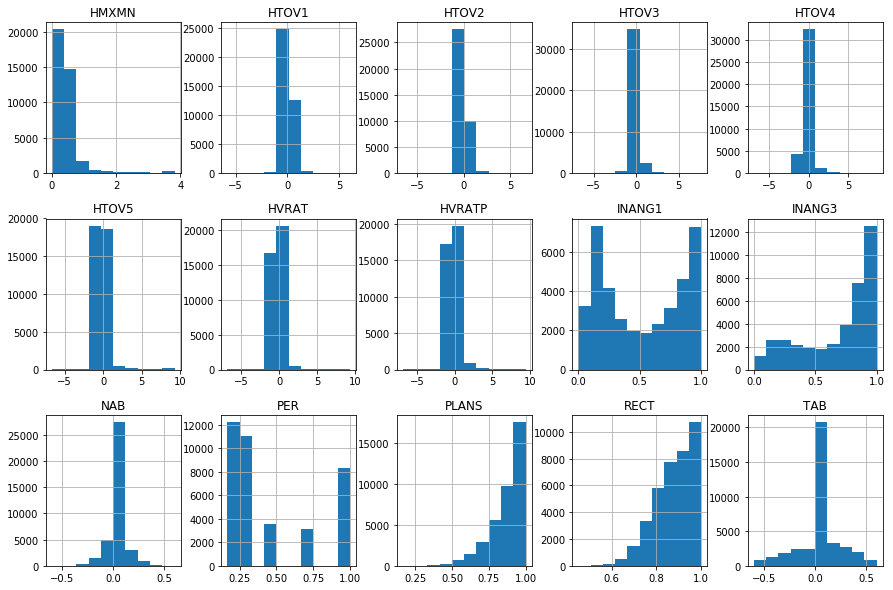

In [87]:
train.hist(figsize=(15,10), column=x_indices, layout=(3,5))

## Density plot

### Train

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ed3ad8748>,
      dtype=object)

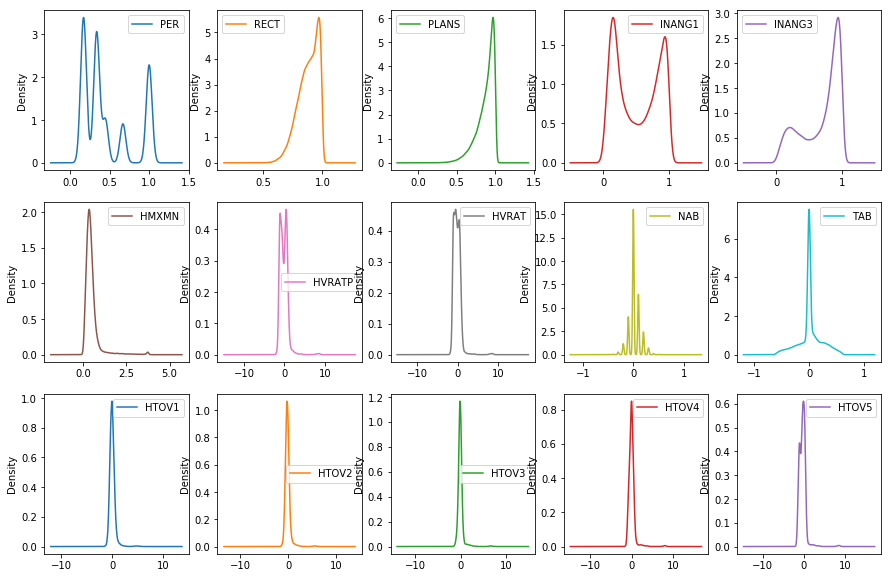

In [40]:
train[x_indices].plot(kind='density', figsize=(15,10), subplots=True, layout=(3,5), sharex=False)

### Test

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ed335ff28>,
      dtype=object)

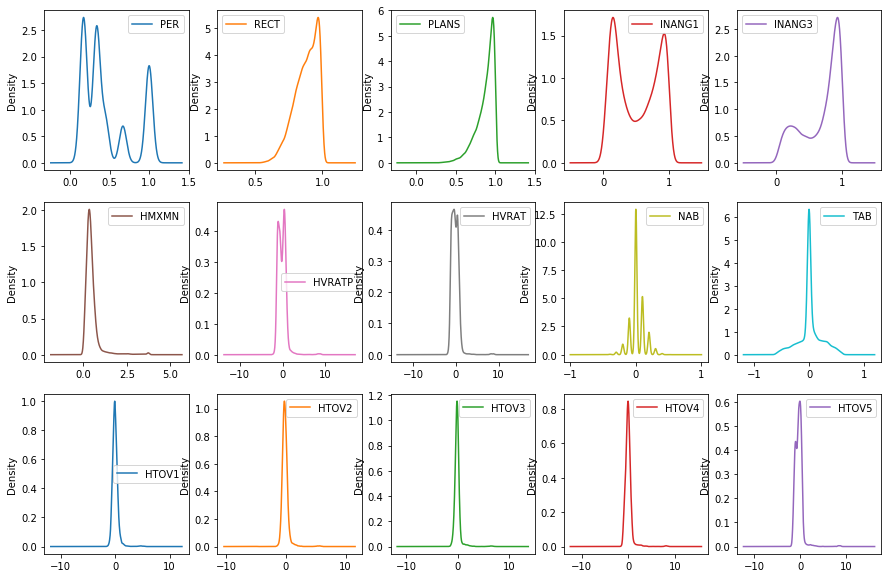

In [41]:
test[x_indices].plot(kind='density', figsize=(15,10), subplots=True, layout=(3,5), sharex=False)

### Correlation

[Text(0,0,'PER'),
 Text(0,0,'RECT'),
 Text(0,0,'PLANS'),
 Text(0,0,'INANG1'),
 Text(0,0,'INANG3'),
 Text(0,0,'HMXMN'),
 Text(0,0,'HVRATP'),
 Text(0,0,'HVRAT'),
 Text(0,0,'NAB'),
 Text(0,0,'TAB'),
 Text(0,0,'HTOV1'),
 Text(0,0,'HTOV2'),
 Text(0,0,'HTOV3'),
 Text(0,0,'HTOV4'),
 Text(0,0,'HTOV5')]

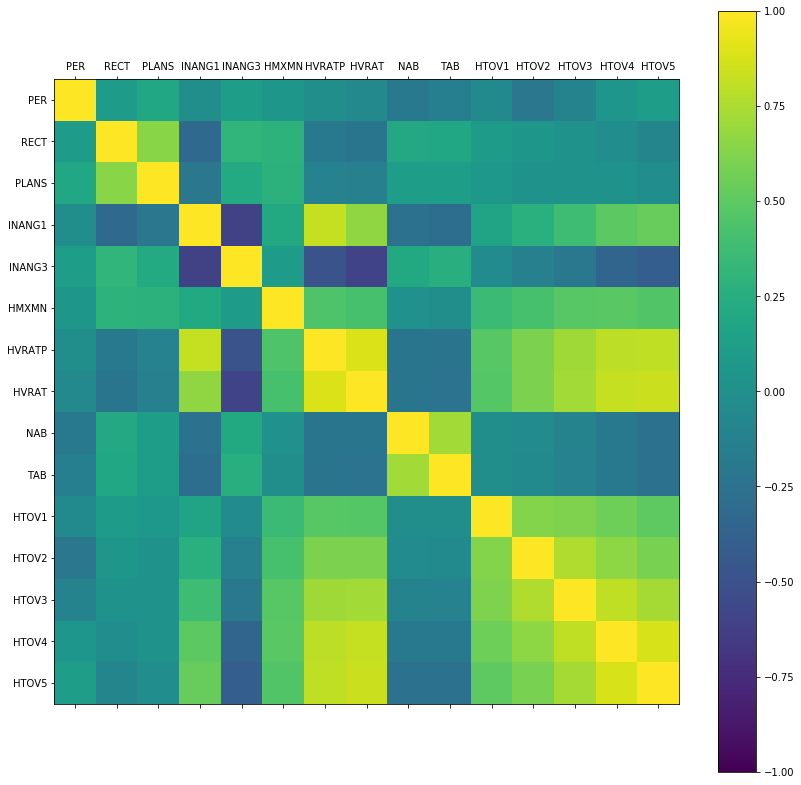

In [49]:
correlations = train[x_indices].corr()
# plot correlation matrix
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,15,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(x_indices)
ax.set_yticklabels(x_indices)

### Scatter plot

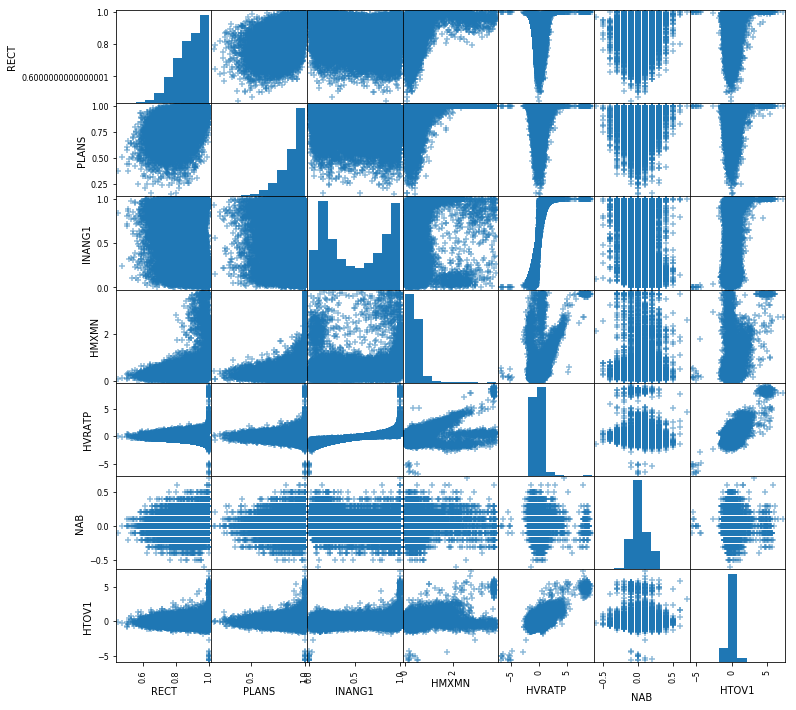

In [57]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
scatter_matrix(train[['RECT', 'PLANS', 'INANG1', 'HMXMN', 'HVRATP', 'NAB', 'HTOV1']], figsize=(12,12), marker='+')
plt.show()

In [51]:
?scatter_matrix

### Extract features and class labels

In [88]:
train_X = train[x_indices].values.astype(float)
train_Y = train[y_indices]

test_X = test[x_indices].values.astype(float)
test_Y = test[y_indices]

train_Y_ = numpy.array(numpy.where(train_Y == 'N', 1, 0), dtype=float)
test_Y_ = numpy.array(numpy.where(test_Y == 'N', 1, 0), dtype=float)

#convert to categorical
train_Y = keras.utils.to_categorical(train_Y_)
test_Y = keras.utils.to_categorical(test_Y_)

test_metadata = test[metadata]

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
print(test_metadata.shape)

(38304, 15) (38304, 2) (12768, 15) (12768, 2)
(12768, 9)


### verification, that if node1 < 0.5 => N (nodes start at 1: node1, node2)

In [89]:
train[y_indices+x_indices]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,tele,0.333333,0.961098,0.942978,0.108049,0.951073,0.107916,-1.267526,-1.267526,0.0,0.000000,0.070615,-0.293430,-0.218705,-0.688470,-1.471724
1,N,0.333333,0.827260,0.939698,0.759642,0.285780,0.415838,0.499398,0.499398,0.1,0.350000,0.306439,-0.420162,-0.227505,0.386287,0.514802
2,regP,0.166667,0.977271,0.944214,0.107171,0.962585,0.474687,-1.429217,-0.988911,0.0,0.180000,0.522462,0.615291,0.160166,-0.151500,-0.760647
3,N,0.666667,0.986251,1.000000,0.794032,0.999668,3.552159,0.554387,0.554387,-0.1,-0.155000,-0.283958,-0.739783,-0.326519,0.031046,-0.152372
4,tele,0.444444,0.941820,0.934873,0.137990,0.966888,0.375598,-1.073314,-1.067414,0.0,0.000000,-0.124386,-0.319017,-0.255335,-0.799879,-0.857255
5,N,1.000000,0.981440,0.984884,0.232826,0.880975,0.295804,-1.033558,-1.033558,0.1,0.170000,-0.418725,-0.733841,-0.665737,0.003156,0.388357
6,regS,0.333333,0.962354,0.925690,0.898608,0.105093,0.750335,0.863342,1.058654,0.0,0.000000,0.447407,1.635730,1.552188,1.513771,0.548354
7,regP,0.333333,0.945574,0.967772,0.283251,0.947238,0.360966,-0.773545,-0.531265,0.1,0.330000,0.054293,-0.270543,0.042458,-0.348378,-0.837349
8,regS,0.333333,0.886886,0.837529,0.983913,0.211320,0.445956,0.764306,0.764306,0.0,0.000000,0.457980,0.098462,-0.435992,0.529433,0.059739
9,regP,0.166667,0.992687,0.975809,0.197214,0.881611,0.710939,-1.231207,-0.979107,0.2,0.395000,0.349469,0.039162,0.103808,-0.377753,-0.943597


In [90]:
train_Y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

#### Ground truth for all 4 classes

In [91]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['N', 'regP', 'regS', 'tele'])
test_Y_GT = le.transform(test[y_indices])
train_Y_GT = le.transform(train[y_indices])
test_Y_GT[:20]

/dvlscratch/SHI/users/hofman/ML/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2, 3, 0, 0, 3, 1, 3, 1, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

# Neural network

In [92]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

In [93]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model = Sequential()
model.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
adam = Adam(lr=0.0001) #, clipnorm, clipvalue=0.5)

model.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [95]:
hist_keys = ('acc', 'val_acc', 'loss', 'val_loss')

In [96]:
history = {k : [] for k in hist_keys}

In [102]:
h = model.fit(train_X[:], train_Y[:], 
          epochs=500, 
          batch_size=512, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=(test_X, test_Y))

history = {k : history[k] + h.history[k] for k in hist_keys}

Train on 38304 samples, validate on 12768 samples
Epoch 1/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3436 - acc: 0.8461 - val_loss: 0.3550 - val_acc: 0.8420
Epoch 2/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3435 - acc: 0.8459 - val_loss: 0.3549 - val_acc: 0.8409
Epoch 3/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3435 - acc: 0.8463 - val_loss: 0.3549 - val_acc: 0.8413
Epoch 4/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3434 - acc: 0.8456 - val_loss: 0.3550 - val_acc: 0.8412
Epoch 5/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3435 - acc: 0.8461 - val_loss: 0.3549 - val_acc: 0.8412
Epoch 6/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3435 - acc: 0.8460 - val_loss: 0.3549 - val_acc: 0.8414
Epoch 7/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3435 - acc: 0.8463 - val_loss: 0.3549 - val_acc

38304/38304 [==============================] - 0s 4us/step - loss: 0.3431 - acc: 0.8464 - val_loss: 0.3547 - val_acc: 0.8423
Epoch 61/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3431 - acc: 0.8465 - val_loss: 0.3548 - val_acc: 0.8424
Epoch 62/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3431 - acc: 0.8471 - val_loss: 0.3547 - val_acc: 0.8408
Epoch 63/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3430 - acc: 0.8461 - val_loss: 0.3546 - val_acc: 0.8413
Epoch 64/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3431 - acc: 0.8459 - val_loss: 0.3545 - val_acc: 0.8409
Epoch 65/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3431 - acc: 0.8468 - val_loss: 0.3545 - val_acc: 0.8412
Epoch 66/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3430 - acc: 0.8466 - val_loss: 0.3547 - val_acc: 0.8412
Epoch 67/500
38304/38304 [=====================

38304/38304 [==============================] - 0s 4us/step - loss: 0.3428 - acc: 0.8467 - val_loss: 0.3543 - val_acc: 0.8406
Epoch 120/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3427 - acc: 0.8469 - val_loss: 0.3544 - val_acc: 0.8427
Epoch 121/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3427 - acc: 0.8473 - val_loss: 0.3545 - val_acc: 0.8427
Epoch 122/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3428 - acc: 0.8468 - val_loss: 0.3544 - val_acc: 0.8418
Epoch 123/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3428 - acc: 0.8469 - val_loss: 0.3542 - val_acc: 0.8416
Epoch 124/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3427 - acc: 0.8470 - val_loss: 0.3542 - val_acc: 0.8420
Epoch 125/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3427 - acc: 0.8471 - val_loss: 0.3542 - val_acc: 0.8411
Epoch 126/500
38304/38304 [==============

38304/38304 [==============================] - 0s 4us/step - loss: 0.3423 - acc: 0.8471 - val_loss: 0.3540 - val_acc: 0.8428
Epoch 179/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3424 - acc: 0.8469 - val_loss: 0.3538 - val_acc: 0.8425
Epoch 180/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3424 - acc: 0.8472 - val_loss: 0.3539 - val_acc: 0.8425
Epoch 181/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3424 - acc: 0.8471 - val_loss: 0.3538 - val_acc: 0.8419
Epoch 182/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3422 - acc: 0.8476 - val_loss: 0.3540 - val_acc: 0.8430
Epoch 183/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3424 - acc: 0.8472 - val_loss: 0.3539 - val_acc: 0.8426
Epoch 184/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3424 - acc: 0.8474 - val_loss: 0.3539 - val_acc: 0.8423
Epoch 185/500
38304/38304 [==============

38304/38304 [==============================] - 0s 4us/step - loss: 0.3421 - acc: 0.8473 - val_loss: 0.3535 - val_acc: 0.8423
Epoch 238/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3421 - acc: 0.8472 - val_loss: 0.3536 - val_acc: 0.8428
Epoch 239/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3421 - acc: 0.8475 - val_loss: 0.3535 - val_acc: 0.8429
Epoch 240/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3421 - acc: 0.8475 - val_loss: 0.3537 - val_acc: 0.8427
Epoch 241/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3421 - acc: 0.8475 - val_loss: 0.3535 - val_acc: 0.8423
Epoch 242/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3422 - acc: 0.8473 - val_loss: 0.3535 - val_acc: 0.8423
Epoch 243/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3421 - acc: 0.8479 - val_loss: 0.3535 - val_acc: 0.8424
Epoch 244/500
38304/38304 [==============

38304/38304 [==============================] - 0s 4us/step - loss: 0.3420 - acc: 0.8474 - val_loss: 0.3534 - val_acc: 0.8428
Epoch 297/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3419 - acc: 0.8475 - val_loss: 0.3537 - val_acc: 0.8439
Epoch 298/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3419 - acc: 0.8475 - val_loss: 0.3534 - val_acc: 0.8423
Epoch 299/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3419 - acc: 0.8476 - val_loss: 0.3534 - val_acc: 0.8426
Epoch 300/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3420 - acc: 0.8477 - val_loss: 0.3534 - val_acc: 0.8433
Epoch 301/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3419 - acc: 0.8473 - val_loss: 0.3533 - val_acc: 0.8431
Epoch 302/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3419 - acc: 0.8476 - val_loss: 0.3535 - val_acc: 0.8428
Epoch 303/500
38304/38304 [==============

38304/38304 [==============================] - 0s 4us/step - loss: 0.3418 - acc: 0.8474 - val_loss: 0.3532 - val_acc: 0.8427
Epoch 356/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3418 - acc: 0.8478 - val_loss: 0.3533 - val_acc: 0.8435
Epoch 357/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3417 - acc: 0.8476 - val_loss: 0.3532 - val_acc: 0.8429
Epoch 358/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3418 - acc: 0.8476 - val_loss: 0.3532 - val_acc: 0.8426
Epoch 359/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3418 - acc: 0.8476 - val_loss: 0.3534 - val_acc: 0.8436
Epoch 360/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3419 - acc: 0.8474 - val_loss: 0.3533 - val_acc: 0.8433
Epoch 361/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3418 - acc: 0.8478 - val_loss: 0.3532 - val_acc: 0.8429
Epoch 362/500
38304/38304 [==============

38304/38304 [==============================] - 0s 4us/step - loss: 0.3416 - acc: 0.8480 - val_loss: 0.3531 - val_acc: 0.8436
Epoch 415/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3417 - acc: 0.8479 - val_loss: 0.3531 - val_acc: 0.8434
Epoch 416/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3417 - acc: 0.8477 - val_loss: 0.3531 - val_acc: 0.8434
Epoch 417/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3417 - acc: 0.8479 - val_loss: 0.3532 - val_acc: 0.8437
Epoch 418/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3416 - acc: 0.8476 - val_loss: 0.3531 - val_acc: 0.8435
Epoch 419/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3416 - acc: 0.8477 - val_loss: 0.3532 - val_acc: 0.8433
Epoch 420/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3417 - acc: 0.8475 - val_loss: 0.3531 - val_acc: 0.8432
Epoch 421/500
38304/38304 [==============

38304/38304 [==============================] - 0s 4us/step - loss: 0.3415 - acc: 0.8477 - val_loss: 0.3531 - val_acc: 0.8433
Epoch 474/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3416 - acc: 0.8482 - val_loss: 0.3532 - val_acc: 0.8436
Epoch 475/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3416 - acc: 0.8475 - val_loss: 0.3530 - val_acc: 0.8431
Epoch 476/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3416 - acc: 0.8476 - val_loss: 0.3530 - val_acc: 0.8430
Epoch 477/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3416 - acc: 0.8474 - val_loss: 0.3531 - val_acc: 0.8438
Epoch 478/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3416 - acc: 0.8479 - val_loss: 0.3532 - val_acc: 0.8445
Epoch 479/500
38304/38304 [==============================] - 0s 4us/step - loss: 0.3416 - acc: 0.8480 - val_loss: 0.3531 - val_acc: 0.8433
Epoch 480/500
38304/38304 [==============

In [103]:
train_Y[train_Y==0].shape, train_Y[train_Y==1].shape
test_Y[test_Y[:,0]==1].shape, test_Y[test_Y[:,1]==1].shape

((6384, 2), (6384, 2))

In [104]:
test_Y

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

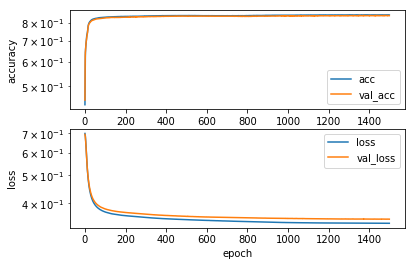

In [105]:
plot(history, semilog=True)

In [106]:
# calculate predicted values
Y_pred_ = model.predict(test_X)
# predictions are outputted as floats from [0,1]
print(Y_pred_[:10])

[[8.4241599e-01 1.5758403e-01]
 [5.7896149e-01 4.2103851e-01]
 [2.6738256e-01 7.3261744e-01]
 [1.4287136e-01 8.5712862e-01]
 [9.9497396e-01 5.0260262e-03]
 [9.9957836e-01 4.2166893e-04]
 [9.9872297e-01 1.2770431e-03]
 [9.7871470e-01 2.1285310e-02]
 [2.9666314e-01 7.0333689e-01]
 [9.9964386e-01 3.5613953e-04]]


In [107]:
Y_pred_.sum(axis=1).min(), Y_pred_.sum(axis=1).max()

(0.9999997, 1.0000002)

In [108]:
Y_pred = numpy.argmax(Y_pred_, axis=1)
Y_pred[:20]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [109]:
from sklearn.metrics import confusion_matrix

# we must translate it to 0, 1 based on thresholding at 0.5
# where < 0.5 set to 0, to 1 otherwise
#Y_pred = numpy.where(Y_pred < 0.5, 0, 1)

# calculate confusion matrix
conf_mat = confusion_matrix(test_Y_, Y_pred)
print(conf_mat)

[[5414  970]
 [1032 5352]]


In [110]:
## confusion matrix on Train?
Y_pred = numpy.argmax(model.predict(train_X), axis=1)
conf_mat = confusion_matrix(train_Y_, Y_pred)
print(conf_mat)

[[16404  2748]
 [ 3069 16083]]


In [111]:
#eval on test data
model.evaluate(test_X, test_Y)

12768/12768 [==============================] - 0s 6us/step


[0.35296958281581564, 0.8432017543859649]

In [112]:
model.evaluate(train_X, train_Y)

38304/38304 [==============================] - 0s 6us/step


[0.3413363319565678, 0.8481359649122807]

In [113]:
#save model and weights, NC = nodes correct
model.save('URZ_model_15-6-2_norm_NC_b2017_NTPS.h5')

# Neural network TP vs S 

* we need a new dataset for this

## Dataset for TP vs S

In [114]:
print(TPS_train.shape, TPS_test.shape)

(19152, 25) (6384, 25)


In [115]:
train_X_TPS = TPS_train[x_indices].values.astype(float)
train_Y_TPS = TPS_train[y_indices]

test_X_TPS = TPS_test[x_indices].values.astype(float)
test_Y_TPS = TPS_test[y_indices]

#regS = 0, T/regP = 1
train_Y_TPS_ = numpy.array(numpy.where(train_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)
test_Y_TPS_ = numpy.array(numpy.where(test_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)

#convert to categorical
train_Y_TPS = keras.utils.to_categorical(train_Y_TPS_)
test_Y_TPS = keras.utils.to_categorical(test_Y_TPS_)

print(train_X_TPS.shape, train_Y_TPS.shape, test_X_TPS.shape, test_Y_TPS.shape)

(19152, 15) (19152, 2) (6384, 15) (6384, 2)


### test if node3 < 0.5 => S

In [116]:
TPS_train[y_indices+x_indices]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,tele,0.666667,0.882568,0.958373,0.157113,0.904336,0.485956,-0.821541,-0.821541,0.0,0.000,0.464077,0.238160,-0.285506,-0.241041,-0.927449
1,tele,0.666667,0.970364,0.907617,0.208997,0.976398,0.394147,-1.056929,-0.780702,0.0,0.000,-0.140690,-0.259506,-0.345500,-0.357016,-0.012361
2,regP,0.444444,0.972336,0.968170,0.287208,0.719656,0.099224,-0.822671,-0.637867,0.1,0.100,0.839792,-0.464646,0.022784,-0.850822,-0.665843
3,regP,0.333333,0.961154,0.968608,0.157537,0.887799,0.220673,-1.143233,-1.021936,0.0,0.000,0.925975,0.187115,-0.342508,-0.593755,-1.253105
4,tele,0.333333,0.921997,0.868067,0.323496,0.944155,0.418986,-0.635144,-0.634917,0.0,0.000,-0.438348,0.300001,-0.528825,-0.389658,-1.141463
5,regS,0.333333,0.862547,0.896826,0.941626,0.125504,0.397756,0.845404,0.828228,-0.1,-0.440,0.168846,-0.144728,0.308528,0.911577,0.127363
6,regP,0.333333,0.903909,0.719782,0.143259,0.940803,0.159849,-0.904157,-0.318353,0.1,0.320,0.073768,0.243717,-0.055781,-0.872731,-0.956776
7,regS,0.166667,0.880015,0.773358,0.474919,0.713135,0.206889,-0.271998,-0.294983,0.0,0.000,-0.015849,-0.421151,-0.077930,-0.210179,-0.364893
8,tele,0.666667,0.995970,0.995814,0.267105,0.733279,0.643558,-0.982717,-0.982717,0.0,0.000,-0.493044,-0.791641,-1.105445,-0.871585,-1.040251
9,tele,1.000000,0.972860,0.976111,0.940441,0.155722,0.827822,1.152960,1.511033,0.1,0.160,0.562585,0.434536,0.901683,0.158088,0.107082


In [117]:
train_Y_TPS

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

### Manually added datasets for testing

In [118]:
#those manually added
nsm = df_S_all[df_S_all['SOURCE'] == 'M'].shape[0]
npm = df_P_all[df_P_all['SOURCE'] == 'M'].shape[0]
ntm = df_T_all[df_T_all['SOURCE'] == 'M'].shape[0]
nnm = df_N_all[df_N_all['SOURCE'] == 'M'].shape[0]

#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
man_samp_count = min(nsm, npm, ntm)

#sample TPS dataset, random_state is a seed
mssS = df_S_all[df_S_all['SOURCE'] == 'M'].sample(man_samp_count, random_state=11)
mssP = df_P_all[df_P_all['SOURCE'] == 'M'].sample(man_samp_count)
mssT = df_T_all[df_T_all['SOURCE'] == 'M'].sample(man_samp_count)
MTPS_data = pd.concat([mssS, mssP, mssT])


#normalize

MTPS_data_norm = MTPS_data.copy(deep=True)
MTPS_data_norm['INANG1'] /= 90.
MTPS_data_norm['INANG3'] /= 90.
MTPS_data_norm['HMXMN'] = numpy.log10(MTPS_data['HMXMN'])
MTPS_data_norm['HVRATP'] = numpy.log10(MTPS_data['HVRATP'])
MTPS_data_norm['HVRAT'] = numpy.log10(MTPS_data['HVRAT'])
MTPS_data_norm['HTOV1'] = numpy.log10(MTPS_data['HTOV1'])
MTPS_data_norm['HTOV2'] = numpy.log10(MTPS_data['HTOV2'])
MTPS_data_norm['HTOV3'] = numpy.log10(MTPS_data['HTOV3'])
MTPS_data_norm['HTOV4'] = numpy.log10(MTPS_data['HTOV4'])
MTPS_data_norm['HTOV5'] = numpy.log10(MTPS_data['HTOV5'])

#manually added noise makes nos sense - we do not sanmple N

#lets shuffle dataset
MTPS_data_norm = MTPS_data_norm.sample(frac=1).reset_index(drop=True)

manual_X = MTPS_data_norm[x_indices].values.astype(float)
#regS = 0, T/regP = 1
manual_Y_TPS_ = numpy.array(numpy.where(MTPS_data_norm[y_indices] == 'regS', 1, 0), dtype=float)
manual_Y_TPS = keras.utils.to_categorical(manual_Y_TPS_)

print(manual_X.shape, manual_Y_TPS.shape, manual_Y_TPS_.shape)

(6006, 15) (6006, 2) (6006, 1)


#### Manual dataset ground truth

In [119]:
manual_Y_GT = le.transform(MTPS_data_norm[y_indices])
manual_Y_GT[:10]

/dvlscratch/SHI/users/hofman/ML/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2, 3, 2, 1, 1, 3, 1, 2, 2, 2])

### Neural network

In [120]:
history_TPS = {k : [] for k in hist_keys}

In [121]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TPS = Sequential()
model_TPS.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TPS.add(Dense(2, activation='sigmoid'))

model_TPS.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [122]:
model_TPS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [129]:
h = model_TPS.fit(train_X_TPS[:], train_Y_TPS[:], 
          epochs=500, 
          batch_size=512, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([test_X_TPS, test_Y_TPS]))

history_TPS = {k : history_TPS[k] + h.history[k] for k in hist_keys}

Train on 19152 samples, validate on 6384 samples
Epoch 1/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9093 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 2/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2103 - acc: 0.9089 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 3/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2103 - acc: 0.9090 - val_loss: 0.2238 - val_acc: 0.9037
Epoch 4/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2103 - acc: 0.9091 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 5/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9088 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 6/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9088 - val_loss: 0.2238 - val_acc: 0.9037
Epoch 7/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2103 - acc: 0.9091 - val_loss: 0.2238 - val_acc:

19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9090 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 61/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9090 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 62/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2103 - acc: 0.9088 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 63/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2103 - acc: 0.9090 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 64/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9084 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 65/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9087 - val_loss: 0.2237 - val_acc: 0.9043
Epoch 66/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9093 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 67/500
19152/19152 [=====================

19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9090 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 120/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9093 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 121/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9083 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 122/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9091 - val_loss: 0.2238 - val_acc: 0.9043
Epoch 123/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9087 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 124/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9095 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 125/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9086 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 126/500
19152/19152 [==============

19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9082 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 179/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9093 - val_loss: 0.2238 - val_acc: 0.9039
Epoch 180/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9089 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 181/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9089 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 182/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9090 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 183/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9094 - val_loss: 0.2238 - val_acc: 0.9039
Epoch 184/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9087 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 185/500
19152/19152 [==============

19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9084 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 238/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9086 - val_loss: 0.2238 - val_acc: 0.9044
Epoch 239/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9094 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 240/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9090 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 241/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9091 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 242/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9088 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 243/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9085 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 244/500
19152/19152 [==============

19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9091 - val_loss: 0.2239 - val_acc: 0.9041
Epoch 297/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9091 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 298/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9084 - val_loss: 0.2238 - val_acc: 0.9037
Epoch 299/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9092 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 300/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9090 - val_loss: 0.2239 - val_acc: 0.9038
Epoch 301/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9093 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 302/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9093 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 303/500
19152/19152 [==============

19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9092 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 356/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9089 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 357/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9090 - val_loss: 0.2239 - val_acc: 0.9038
Epoch 358/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9084 - val_loss: 0.2238 - val_acc: 0.9037
Epoch 359/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9095 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 360/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9084 - val_loss: 0.2239 - val_acc: 0.9038
Epoch 361/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9093 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 362/500
19152/19152 [==============

19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9081 - val_loss: 0.2239 - val_acc: 0.9039
Epoch 415/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9090 - val_loss: 0.2238 - val_acc: 0.9040
Epoch 416/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9090 - val_loss: 0.2239 - val_acc: 0.9041
Epoch 417/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9082 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 418/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9091 - val_loss: 0.2239 - val_acc: 0.9040
Epoch 419/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2102 - acc: 0.9084 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 420/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9093 - val_loss: 0.2238 - val_acc: 0.9041
Epoch 421/500
19152/19152 [==============

19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9090 - val_loss: 0.2239 - val_acc: 0.9040
Epoch 474/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9082 - val_loss: 0.2239 - val_acc: 0.9040
Epoch 475/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9091 - val_loss: 0.2239 - val_acc: 0.9041
Epoch 476/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9091 - val_loss: 0.2239 - val_acc: 0.9040
Epoch 477/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9086 - val_loss: 0.2239 - val_acc: 0.9041
Epoch 478/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9093 - val_loss: 0.2238 - val_acc: 0.9038
Epoch 479/500
19152/19152 [==============================] - 0s 4us/step - loss: 0.2101 - acc: 0.9093 - val_loss: 0.2239 - val_acc: 0.9040
Epoch 480/500
19152/19152 [==============

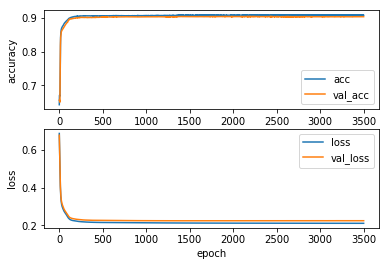

In [130]:
plot(history_TPS)

In [131]:
#NC = nodes correct
model_TPS.save('URZ_model_15-6-2_norm_NC_b2017_TPS.h5')

In [132]:
model_TPS.evaluate(test_X_TPS, test_Y_TPS)

6384/6384 [==============================] - 0s 6us/step


[0.22384441111768996, 0.9041353383458647]

#### Test data confusion matrix

In [133]:
Y_pred = numpy.reshape(numpy.argmax(model_TPS.predict(test_X_TPS), axis=1), (test_X_TPS.shape[0],1))

# calculate confusion matrix
C = confusion_matrix(test_Y_TPS_, Y_pred)
print(C)

[[3665  521]
 [  91 2107]]


In [134]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 90.41%


#### Just for curiosity -  Manual associations confusion matrix

In [135]:
Y_pred_man = numpy.argmax(model_TPS.predict(manual_X), axis=1)

# calculate confusion matrix
C = confusion_matrix(manual_Y_TPS_, Y_pred_man)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[2957 1047]
 [ 156 1846]]
Accuracy: 79.97%


# Neural network T vs regP 

* we need a new dataset for this

### Dataset for T vs regP

In [136]:
#exclude regS
TP_train = TPS_train[TPS_train['CLASS_PHASE'] != 'regS']
TP_test  = TPS_test [TPS_test ['CLASS_PHASE'] != 'regS']

In [137]:
train_X_TP = TP_train[x_indices].values.astype(float)
train_Y_TP = TP_train[y_indices]

test_X_TP = TP_test[x_indices].values.astype(float)
test_Y_TP = TP_test[y_indices]

#regS = 0, T/regP = 1
train_Y_TP_ = numpy.array(numpy.where(train_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)
test_Y_TP_ = numpy.array(numpy.where(test_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)

#convert to categorical
train_Y_TP = keras.utils.to_categorical(train_Y_TP_)
test_Y_TP = keras.utils.to_categorical(test_Y_TP_)

print(train_X_TP.shape, train_Y_TP.shape, test_X_TP.shape, test_Y_TP.shape)

(12838, 15) (12838, 2) (4186, 15) (4186, 2)


### test if node5 < 0.5 => P

In [138]:
TP_train[y_indices + x_indices]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,tele,0.666667,0.882568,0.958373,0.157113,0.904336,0.485956,-0.821541,-0.821541,0.0,0.000,0.464077,0.238160,-0.285506,-0.241041,-0.927449
1,tele,0.666667,0.970364,0.907617,0.208997,0.976398,0.394147,-1.056929,-0.780702,0.0,0.000,-0.140690,-0.259506,-0.345500,-0.357016,-0.012361
2,regP,0.444444,0.972336,0.968170,0.287208,0.719656,0.099224,-0.822671,-0.637867,0.1,0.100,0.839792,-0.464646,0.022784,-0.850822,-0.665843
3,regP,0.333333,0.961154,0.968608,0.157537,0.887799,0.220673,-1.143233,-1.021936,0.0,0.000,0.925975,0.187115,-0.342508,-0.593755,-1.253105
4,tele,0.333333,0.921997,0.868067,0.323496,0.944155,0.418986,-0.635144,-0.634917,0.0,0.000,-0.438348,0.300001,-0.528825,-0.389658,-1.141463
6,regP,0.333333,0.903909,0.719782,0.143259,0.940803,0.159849,-0.904157,-0.318353,0.1,0.320,0.073768,0.243717,-0.055781,-0.872731,-0.956776
8,tele,0.666667,0.995970,0.995814,0.267105,0.733279,0.643558,-0.982717,-0.982717,0.0,0.000,-0.493044,-0.791641,-1.105445,-0.871585,-1.040251
9,tele,1.000000,0.972860,0.976111,0.940441,0.155722,0.827822,1.152960,1.511033,0.1,0.160,0.562585,0.434536,0.901683,0.158088,0.107082
10,tele,0.166667,0.985089,0.969033,0.254518,0.832267,0.382739,-0.978108,-1.262562,0.0,0.000,-0.063604,-0.291263,-0.209906,-0.672245,-1.195840
11,regP,0.333333,0.956265,0.956891,0.259817,0.892011,0.405170,-0.858268,-0.858268,0.1,0.395,0.265488,-0.033137,-0.326958,-0.865673,-0.811336


In [139]:
train_Y_TP

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

### Neural network

In [140]:
history_TP = {k : [] for k in hist_keys}

In [141]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TP = Sequential()
model_TP.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TP.add(Dense(2, activation='sigmoid'))

model_TP.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [147]:
h = model_TP.fit(train_X_TP[:], train_Y_TP[:], 
          epochs=500, 
          batch_size=512, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([test_X_TP, test_Y_TP]))

history_TP = {k : history_TP[k] + h.history[k] for k in hist_keys}

Train on 12838 samples, validate on 4186 samples
Epoch 1/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4440 - acc: 0.8046 - val_loss: 0.4367 - val_acc: 0.8110
Epoch 2/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4440 - acc: 0.8042 - val_loss: 0.4366 - val_acc: 0.8097
Epoch 3/500
12838/12838 [==============================] - 0s 3us/step - loss: 0.4442 - acc: 0.8046 - val_loss: 0.4367 - val_acc: 0.8107
Epoch 4/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4441 - acc: 0.8046 - val_loss: 0.4368 - val_acc: 0.8109
Epoch 5/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4440 - acc: 0.8046 - val_loss: 0.4367 - val_acc: 0.8114
Epoch 6/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4440 - acc: 0.8044 - val_loss: 0.4367 - val_acc: 0.8109
Epoch 7/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4441 - acc: 0.8048 - val_loss: 0.4367 - val_acc:

12838/12838 [==============================] - 0s 4us/step - loss: 0.4439 - acc: 0.8048 - val_loss: 0.4367 - val_acc: 0.8103
Epoch 61/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4439 - acc: 0.8046 - val_loss: 0.4366 - val_acc: 0.8100
Epoch 62/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4440 - acc: 0.8045 - val_loss: 0.4367 - val_acc: 0.8090
Epoch 63/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4439 - acc: 0.8045 - val_loss: 0.4365 - val_acc: 0.8086
Epoch 64/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4439 - acc: 0.8048 - val_loss: 0.4365 - val_acc: 0.8089
Epoch 65/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4439 - acc: 0.8049 - val_loss: 0.4365 - val_acc: 0.8097
Epoch 66/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4439 - acc: 0.8049 - val_loss: 0.4368 - val_acc: 0.8106
Epoch 67/500
12838/12838 [=====================

12838/12838 [==============================] - 0s 4us/step - loss: 0.4438 - acc: 0.8048 - val_loss: 0.4366 - val_acc: 0.8097
Epoch 120/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4438 - acc: 0.8048 - val_loss: 0.4366 - val_acc: 0.8096
Epoch 121/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4441 - acc: 0.8047 - val_loss: 0.4365 - val_acc: 0.8092
Epoch 122/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4438 - acc: 0.8048 - val_loss: 0.4367 - val_acc: 0.8095
Epoch 123/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4438 - acc: 0.8043 - val_loss: 0.4368 - val_acc: 0.8097
Epoch 124/500
12838/12838 [==============================] - 0s 3us/step - loss: 0.4438 - acc: 0.8043 - val_loss: 0.4366 - val_acc: 0.8101
Epoch 125/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4438 - acc: 0.8047 - val_loss: 0.4366 - val_acc: 0.8102
Epoch 126/500
12838/12838 [==============

12838/12838 [==============================] - 0s 4us/step - loss: 0.4437 - acc: 0.8046 - val_loss: 0.4367 - val_acc: 0.8094
Epoch 179/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4437 - acc: 0.8044 - val_loss: 0.4369 - val_acc: 0.8102
Epoch 180/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4437 - acc: 0.8047 - val_loss: 0.4367 - val_acc: 0.8104
Epoch 181/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4437 - acc: 0.8045 - val_loss: 0.4367 - val_acc: 0.8109
Epoch 182/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4437 - acc: 0.8047 - val_loss: 0.4366 - val_acc: 0.8102
Epoch 183/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4436 - acc: 0.8043 - val_loss: 0.4367 - val_acc: 0.8102
Epoch 184/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4437 - acc: 0.8044 - val_loss: 0.4365 - val_acc: 0.8098
Epoch 185/500
12838/12838 [==============

12838/12838 [==============================] - 0s 4us/step - loss: 0.4436 - acc: 0.8047 - val_loss: 0.4365 - val_acc: 0.8097
Epoch 238/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4436 - acc: 0.8041 - val_loss: 0.4366 - val_acc: 0.8097
Epoch 239/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4436 - acc: 0.8040 - val_loss: 0.4365 - val_acc: 0.8097
Epoch 240/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4436 - acc: 0.8041 - val_loss: 0.4365 - val_acc: 0.8100
Epoch 241/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4436 - acc: 0.8045 - val_loss: 0.4364 - val_acc: 0.8084
Epoch 242/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4435 - acc: 0.8046 - val_loss: 0.4364 - val_acc: 0.8094
Epoch 243/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4436 - acc: 0.8046 - val_loss: 0.4364 - val_acc: 0.8096
Epoch 244/500
12838/12838 [==============

12838/12838 [==============================] - 0s 4us/step - loss: 0.4437 - acc: 0.8053 - val_loss: 0.4364 - val_acc: 0.8104
Epoch 297/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4435 - acc: 0.8046 - val_loss: 0.4363 - val_acc: 0.8107
Epoch 298/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4435 - acc: 0.8049 - val_loss: 0.4363 - val_acc: 0.8109
Epoch 299/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4435 - acc: 0.8049 - val_loss: 0.4364 - val_acc: 0.8106
Epoch 300/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4435 - acc: 0.8048 - val_loss: 0.4365 - val_acc: 0.8104
Epoch 301/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4435 - acc: 0.8048 - val_loss: 0.4367 - val_acc: 0.8107
Epoch 302/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4434 - acc: 0.8048 - val_loss: 0.4366 - val_acc: 0.8108
Epoch 303/500
12838/12838 [==============

12838/12838 [==============================] - 0s 4us/step - loss: 0.4434 - acc: 0.8044 - val_loss: 0.4364 - val_acc: 0.8097
Epoch 356/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4434 - acc: 0.8043 - val_loss: 0.4364 - val_acc: 0.8091
Epoch 357/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4434 - acc: 0.8048 - val_loss: 0.4365 - val_acc: 0.8094
Epoch 358/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4434 - acc: 0.8040 - val_loss: 0.4365 - val_acc: 0.8104
Epoch 359/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4433 - acc: 0.8046 - val_loss: 0.4364 - val_acc: 0.8098
Epoch 360/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4434 - acc: 0.8046 - val_loss: 0.4363 - val_acc: 0.8102
Epoch 361/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4434 - acc: 0.8053 - val_loss: 0.4364 - val_acc: 0.8102
Epoch 362/500
12838/12838 [==============

12838/12838 [==============================] - 0s 4us/step - loss: 0.4433 - acc: 0.8046 - val_loss: 0.4364 - val_acc: 0.8103
Epoch 415/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4434 - acc: 0.8051 - val_loss: 0.4363 - val_acc: 0.8098
Epoch 416/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4433 - acc: 0.8048 - val_loss: 0.4362 - val_acc: 0.8094
Epoch 417/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4433 - acc: 0.8048 - val_loss: 0.4363 - val_acc: 0.8095
Epoch 418/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4433 - acc: 0.8046 - val_loss: 0.4363 - val_acc: 0.8091
Epoch 419/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4433 - acc: 0.8046 - val_loss: 0.4365 - val_acc: 0.8094
Epoch 420/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4433 - acc: 0.8053 - val_loss: 0.4366 - val_acc: 0.8100
Epoch 421/500
12838/12838 [==============

12838/12838 [==============================] - 0s 4us/step - loss: 0.4432 - acc: 0.8052 - val_loss: 0.4361 - val_acc: 0.8095
Epoch 474/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4431 - acc: 0.8055 - val_loss: 0.4363 - val_acc: 0.8102
Epoch 475/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4432 - acc: 0.8055 - val_loss: 0.4361 - val_acc: 0.8091
Epoch 476/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4432 - acc: 0.8054 - val_loss: 0.4360 - val_acc: 0.8088
Epoch 477/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4432 - acc: 0.8055 - val_loss: 0.4363 - val_acc: 0.8098
Epoch 478/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4431 - acc: 0.8055 - val_loss: 0.4362 - val_acc: 0.8088
Epoch 479/500
12838/12838 [==============================] - 0s 4us/step - loss: 0.4431 - acc: 0.8057 - val_loss: 0.4363 - val_acc: 0.8101
Epoch 480/500
12838/12838 [==============

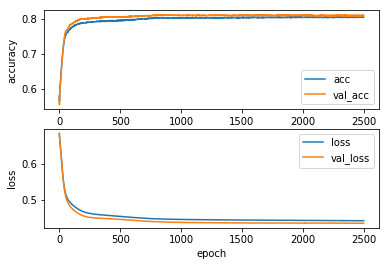

In [148]:
plot(history_TP)

In [149]:
#NC = nodes correct
model_TP.save('URZ_model_15-6-2_norm_NC_b2017_TP.h5')

In [150]:
model_TP.evaluate(test_X_TP, test_Y_TP)

4186/4186 [==============================] - 0s 6us/step


[0.4360341330464241, 0.8098423316384182]

#### Test data confusion matrix

In [151]:
Y_pred = numpy.reshape(numpy.argmax(model_TP.predict(test_X_TP), axis=1), (test_X_TP.shape[0],1))

# calculate confusion matrix
conf_mat = confusion_matrix(test_Y_TP_, Y_pred)
print(conf_mat)

[[1690  425]
 [ 371 1700]]


# Cascade of all three models

In [153]:
from keras.models import load_model

In [154]:
model_NTPS = load_model('URZ_model_15-6-2_norm_NC_b2017_NTPS.h5')
model_STP = load_model('URZ_model_15-6-2_norm_NC_b2017_TPS.h5')
model_PT = load_model('URZ_model_15-6-2_norm_NC_b2017_TP.h5')

In [155]:
def predict_iwt(X, stage=0):
    """
    predicts initial wave type for given featrue vectors
    Class encoding generated by sklearn Label Encoder
    0 - noise
    2 - regS 
    1 - regP
    3 - T
    """
    Y = numpy.arange(X.shape[0])
    
    N_indices = None
    S_indices = None 
    
    if stage >= 1:
        N_indices = [False] * X.shape[0]
        X_PTS = X
        Y_NPTS = numpy.zeros(X.shape[0])
    if stage >= 2:
        S_indices =  [False] * X.shape[0]  # numpy.array([])
        X_PT = X
        Y_PTS = numpy.zeros(X.shape[0])
        
    
    """
    N vs regS, regP, T
    """
    if N_indices is None:
        #predict N vs T,regP,regS
        Y_NPTS = numpy.argmax(model_NTPS.predict(X), axis=1)
        #set which are noise
        N_indices = Y[Y_NPTS == 1]  #  = 0
        #get candidates for TPS
        X_PTS = X[Y_NPTS < 1]
    else:
        print('Skipping N, classifying TPS only')

    """
    regS vs regP, T
    """
    if S_indices is None:    
        #predict regS vs T,regP
        Y_PTS = numpy.argmax(model_STP.predict(X_PTS), axis=1)
        #set which are regS
        S_indices = Y[Y_NPTS < 1][Y_PTS == 1]  # = 2
        #get candidates for regP,T
        X_PT = X_PTS[Y_PTS < 1]
    else:
        print('Skipping N, regS, classifying TP only')

    """
    regP vs T
    """
    #predict regP vs T
    Y_PT = numpy.argmax(model_PT.predict(X_PT), axis=1)
    #set which are regP
    P_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT == 1]  # = 1    
    #set which are T
    T_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT < 1]   # = 3
    #get those which are T
    X_T = X_PT[Y_PT < 1]
    
    Y[N_indices] = 0 # N
    Y[S_indices] = 2 # regS
    Y[P_indices] = 1 # regP 
    Y[T_indices] = 3 # tele
    
    return Y
    

In [156]:
Y = predict_iwt(test_X)

### Overall confusion matrix for test data

In [157]:
test_X.shape, Y.shape, test_Y_GT.shape

((12768, 15), (12768,), (12768,))

In [158]:
C = confusion_matrix(Y, test_Y_GT)
print(C)

[[5352  225  488  257]
 [ 240 1527    6  373]
 [ 637   15 1650  416]
 [ 155  304   54 1069]]


In [159]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 75.17%


#### Let's produce result data frame from metadata and results

In [160]:
class_dict = {0:'N', 1:'regP', 2:'regS', 3:'tele'}
Y_pred_cat = [class_dict[yi] for yi in Y]
print(len(Y_pred_cat))

12768


In [161]:
test_metadata = test[metadata]

In [162]:
#let's add new column to the pandas dataframe
#test_metadata['CLASS_IPHASE_NEW'] = Y_pred_cat  # deprecated - gives warning
test_metadata.assign(CLASS_IPHASE_NEW = pd.Series(Y_pred_cat, index=test_metadata.index)).to_csv('test_set_prediction.txt', na_rep='null',columns=metadata+["CLASS_IPHASE_NEW"]) 

In [163]:
### some experiment section..

In [164]:
test_pred_Y = predict_iwt(test_X)

In [165]:
test_X.shape
train_X.shape

(38304, 15)

In [166]:
test_iphase_Y = le.transform(test['CLASS_IPHASE'])
test_truth_Y = le.transform(test['CLASS_PHASE'])

In [167]:
test_truth_Y.min(), test_truth_Y.max()

(0, 3)

In [168]:
test_iphase_Y.min(), test_iphase_Y.max()

(0, 3)

In [169]:
numpy.sum( ) 

TypeError: sum() missing 1 required positional argument: 'a'

In [170]:
#print('IPHASE:')
C = confusion_matrix(test_pred_Y, test_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[5352  225  488  257]
 [ 240 1527    6  373]
 [ 637   15 1650  416]
 [ 155  304   54 1069]]
Accuracy: 75.17%


### Test data just regS, regP, T - not to be confused with overall statistics on all arrivals in our DB

In [171]:
test_TPS = test[test['CLASS_PHASE'] != 'N']
test_TPS_X = test_TPS[x_indices]
test_TPS_pred_Y = predict_iwt(test_TPS_X)
test_TPS_truth_Y = le.transform(test_TPS['CLASS_PHASE'])
test_TPS_iphase_Y = le.transform(test_TPS['CLASS_IPHASE'])

In [172]:
test_TPS_iphase_Y.min(), test_TPS_iphase_Y.max()

(0, 3)

In [173]:
print('IPHASE:')
C = confusion_matrix(test_TPS_iphase_Y, test_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

IPHASE:
[[   0  319  774  356]
 [   0 1502  149  471]
 [   0   59 1240  359]
 [   0  191   35  929]]
Accuracy: 57.50%


In [174]:
print('NEW PREDICTION')
C = confusion_matrix(test_TPS_pred_Y, test_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

NEW PREDICTION
[[   0  225  488  257]
 [   0 1527    6  373]
 [   0   15 1650  416]
 [   0  304   54 1069]]
Accuracy: 66.51%


* in the test data, the current iwt characterized 1501 as NOISE (first row of confusion matrix)
* our new iwt would characterize 1089 as NOISE
* after re-training, accuracy on the test set rose from 58.68% to 65.82% for regS, regP and T phases

#### ..on train data just to see if it works

In [175]:
Y = predict_iwt(train_X)
C = confusion_matrix(Y, train_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[16083   658  1379   711]
 [  792  4754    22  1160]
 [ 1816    20  4726  1153]
 [  461  1009   187  3373]]
Accuracy: 75.54%


### Overall confusion matrix for all manual associations (no Noise)

In [176]:
C = confusion_matrix(predict_iwt(manual_X, stage=1), manual_Y_GT)
print(C)

Skipping N, classifying TPS only
[[1328   68  384]
 [ 263 1846  784]
 [ 411   88  834]]


In [177]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 66.73%


## Let's try all noise samples we have

In [178]:
# let's get all noise phases not used for training
N_data_diff = pd.concat([df_N_all, N_data]).loc[
    df_N_all.index.symmetric_difference(N_data.index)
]

In [179]:
print(N_data_diff.shape, df_N_all.shape, N_data.shape)
print(N_data_diff.shape[0], 'should equal', df_N_all.shape[0]-N_data.shape[0])

(257867, 25) (283403, 25) (25536, 25)
257867 should equal 257867


In [180]:
N_data_norm = N_data_diff[x_indices].copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(df_N_all['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(df_N_all['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(df_N_all['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(df_N_all['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(df_N_all['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(df_N_all['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(df_N_all['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(df_N_all['HTOV5'])

In [181]:
N_data_norm.shape

(257867, 15)

In [182]:
N_X = N_data_norm[x_indices].values.astype(float)
N_Y = numpy.zeros(N_X.shape[0])

print(N_X.shape, N_Y.shape)

(257867, 15) (257867,)


In [183]:
Y = predict_iwt(N_X)
C = confusion_matrix(Y, N_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[213654      0      0      0]
 [ 12107      0      0      0]
 [ 25218      0      0      0]
 [  6888      0      0      0]]
Accuracy: 82.85%


* From all avaibale noise phases which were not used for training we are able to correctly identify 83.8%

# Let's analyze weights and generate a new weight file!

In [184]:
model_NTPS = load_model('URZ_model_15-6-2_norm_NC_b2017_NTPS.h5')
model_STP = load_model('URZ_model_15-6-2_norm_NC_b2017_TPS.h5')
model_PT = load_model('URZ_model_15-6-2_norm_NC_b2017_TP.h5')

In [185]:
weights_NTPS = model_NTPS.get_weights()
weights_STP = model_STP.get_weights()
weights_PT = model_PT.get_weights()

In [186]:
model_NTPS.get_config()

[{'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'batch_input_shape': (None, 15),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dtype': 'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'dense_1',
   'trainable': True,
   'units': 6,
   'use_bias': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kern

In [187]:
for w in weights_NTPS:
    print(w.shape)

(15, 6)
(6,)
(6, 2)
(2,)


In [188]:
for w in weights_STP:
    print(w.shape)
    print(w)

(15, 6)
[[ 5.8478665  -5.032953    1.8389305   0.99567455  0.3062552  -4.261927  ]
 [ 1.5263252   0.01462127 -0.8807645  -0.3886471   1.6210933   1.3118964 ]
 [ 0.6015416   0.13644895  1.5632303  -0.39800438  0.10257598  2.4253993 ]
 [-1.4033757  -0.8075286  -2.4566402  -2.0317829  -0.08502435 -4.4646106 ]
 [-2.2210946  -1.5824511   0.35599676  2.0225086  -0.03552945  4.179057  ]
 [-1.2482035  -1.372656   -0.34105554  0.9927031  -0.3674819  -0.65187365]
 [-0.9373123  -1.7962953  -0.42516714  1.0322387   0.3969132   2.8372571 ]
 [-1.4287976   3.8152163  -0.4768699   0.937191    0.1361745  -1.8733965 ]
 [-3.8945634  -2.8927913  -5.189778    2.7606335   1.6902777  -1.6299573 ]
 [-2.8483734   7.786834    2.4863887  -2.7429674   1.4312958   1.7526245 ]
 [-1.0817071  -0.27091426 -0.20218308 -0.12344977  0.03813476  0.04900149]
 [ 1.5880547   0.9582509  -2.7227979   1.522055   -0.10548145 -0.12467298]
 [ 3.0334074  -3.7569742  -4.819405    4.4855437   0.22599314  0.54995215]
 [-3.2127764  -8.

In [189]:
for w in weights_PT:
    print(w.shape)
    print(w)

(15, 6)
[[-4.5321426  -2.3206992  -1.1252053  -7.9360805   3.6307385   0.6641658 ]
 [ 0.6105982  -0.33348265 -0.7247731   0.8836623  -0.9755786  -1.8861399 ]
 [-0.70536315 -0.86980075  1.0203072  -0.86522585  0.57791066 -0.06255864]
 [-3.0337205   1.9685638  -1.7291902  -1.1093358  -0.38044664 -1.7166578 ]
 [ 0.55730546  0.11850964  1.2312227   2.1230557  -0.89594436  0.59999895]
 [ 0.4584723  -0.33585298  0.03324157  1.4736813   3.0760381  -1.2983308 ]
 [ 0.06205886 -0.6737439   0.27489057 -0.33893964 -1.0329112   0.29248005]
 [ 0.5783386   1.2178854   1.3272338   0.43352124  0.6704343  -1.2126989 ]
 [ 5.814353   -1.4717473  -0.03534963 -1.6265363  -3.3497605  -1.7641939 ]
 [ 9.347705   -2.5194054   1.5145575  -3.1117196  -4.6199284  -3.942284  ]
 [-0.25152105 -0.03643068 -0.6028741  -0.01521262  0.20082231  0.18080786]
 [ 1.4165443   0.96950376 -0.64585406  0.26569274  0.01514116  1.4508675 ]
 [ 1.5075616   0.63739896 -1.5614668  -0.34320885 -0.5515638   0.73029035]
 [ 0.30727452  2.

### Let's export it to a weigth file using a template

In [190]:
station_name = 'URZ'

In [191]:
# open template
with open(os.path.join('templates','%s.template' % station_name)) as f:
    template = f.read()
    #print(s)

In [192]:
import datetime
#put name to template
s = template.replace('{{station_name}}', station_name)
s = s.replace('{{date}}', datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))

In [193]:
weight_idents = ('TPSN', 'TPS', 'TP')
weights = (weights_NTPS, weights_STP, weights_PT)

In [194]:
#prepare weights
for ident, w in zip(weight_idents, weights):
    weights_layer_1 = ""
    for i in range(w[0].shape[0]):
        weights_layer_1 += ' '.join(list(map(lambda x: "%7.6f" % x, w[0][i,:])))
        if i < w[0].shape[0] - 1:
            weights_layer_1  += '\n'        
        
    bias_layer_1 = ' '.join(list(map(lambda x: "%7.6f" % x, w[1])))
    
    weights_layer_2 = ""
    for i in range(w[2].shape[0]):
        weights_layer_2 += ' '.join(list(map(lambda x: "%7.6f" % x, w[2][i,:])))
        if i < w[2].shape[0] - 1:
            weights_layer_2  += '\n'        
        
    bias_layer_2 = ' '.join(list(map(lambda x: "%7.6f" % x, w[3])))
    
    #put coefficients into template
    s = s.replace('{{%s_bias_layer_1}}' % ident, bias_layer_1) 
    s = s.replace('{{%s_weights_layer_1}}' % ident, weights_layer_1)
    s = s.replace('{{%s_bias_layer_2}}' % ident, bias_layer_2)
    s = s.replace('{{%s_weights_layer_2}}' % ident, weights_layer_2)
    
#print(bias_layer_1)
#print(weights_layer_1)
#print(bias_layer_2)
#print(weights_layer_2)

In [195]:
print(s)

*-- URZ.nn
*-- Comments ...
*-- Auxiliary 3C station URZ uses the new weights from retraining by RH
*-- Generated 2018/04/04 10:52:30
*-- {{training_summary}}
URZ
3
60.000000
  0.25   0.50   1.00   2.00   4.00
URZ TPS-N
628 3 16 7 2
-3.994685 -0.755888 0.903069 2.702108 -3.779376 -2.641291
0.455732 4.686640 0.383038 -4.710582 -2.096401 0.283930
0.938374 -3.005877 0.157150 -2.017283 1.706746 2.230778
-0.450780 -0.476287 -2.369338 0.393661 -1.139847 0.069599
-1.204098 -1.001628 -0.657275 -1.210498 -2.189292 0.684389
-0.610085 0.072204 0.779547 0.405391 1.535174 -1.283980
-0.512825 -0.006189 0.084905 1.218340 2.008622 0.243885
0.439002 0.458984 0.237362 0.131724 -0.162169 -0.544112
-0.684550 -0.665428 0.703674 0.341318 0.539138 -0.668965
3.315119 -1.310946 -2.583002 -0.865736 1.118465 17.927109
0.141976 0.932195 -1.229871 2.237007 2.713938 -0.891766
0.022667 0.149925 0.135585 0.098894 0.251767 -0.055839
-1.334211 -0.744954 0.251282 0.223391 0.777167 0.133387
-2.640821 -0.304777 1.007284 -

In [196]:
#save it
with open(os.path.join('nn_weights','%s_EGU.nn' % station_name), 'w+') as f:
    f.write(s)